In [1]:
import numpy as np
import math
import os
import pandas as pd
from operator import itemgetter
import pickle
from tqdm import tqdm
import scipy
import random
import yaml

import difflib
import string
import json

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
import seaborn as sns


from sklearn.utils import shuffle

import torch
from torch import Tensor
import datasets
from datasets import load_dataset
from embedding import BertHuggingfaceMLM, BertHuggingface
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from geometrical_bias import SAME, WEAT, GeneralizedWEAT, DirectBias, RIPA, MAC, normalize, cossim, EmbSetList, EmbSet, GeometricBias, cossim
from unmasking_bias import PLLBias

from utils import CLFHead, SimpleCLFHead, CustomModel, JigsawDataset, BiosDataset, DebiasPipeline, upsample_defining_embeddings, WordVectorWrapper
from transformers import AutoModelForMaskedLM, AutoTokenizer
import time

/home/saschroeder/anaconda3/envs/plmbias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-27 10:29:03.036121: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 10:29:03.225192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 10:29:03.225252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27

In [2]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [3]:
with open('data/protected_groups.json', 'r') as f:
    pg_config = json.load(f)
    
groups_by_bias_types = pg_config['groups_by_bias_types']
terms_by_groups = pg_config['terms_by_groups']

attributes = [terms_by_groups[group] for group in groups_by_bias_types['gender']]

In [4]:
with open('data/batch_size_lookup_1080.json', 'r') as f:
    batch_size_lookup = json.load(f)

In [5]:
for bt in groups_by_bias_types.keys():
    print(bt)
    for group in groups_by_bias_types[bt]:
        print(group, len(terms_by_groups[group]))

race-color
black 15
white 15
asian 15
socioeconomic
poor 5
rich 6
gender
male 25
female 25
sexual-orientation
homosexual 4
heterosexual 4
bisexual 4
religion
christian 14
muslim 14
jewish 14
buddhist 14
hindu 14
age
old 8
young 8


In [8]:
def merge_results(results, new, bias_type):
    for score, res in results[bias_type].items():

        if res == {}:
            #print("add new results")
            results[bias_type][score] = new[score]
        else:
            #print("append new results")
            for n, n_res in res.items():
                results[bias_type][score][n] += new[score][n]

    #print(results)
    return results

def test_attribute_robustness(bias_types=['race-color','gender','age','religion'], models=['bert-base-uncased', 'roberta-base']):
    res_by_bias_type = {bias_type: {'SAME': {}, 'DB': {}, 'gWEAT': {}} for bias_type in bias_types}
    
    for model in models:
        batch_size = 1
        if model in batch_size_lookup.keys():
            batch_size = batch_size_lookup[model]
        lm = BertHuggingface(model_name=model, batch_size=batch_size, num_labels=2)
        for bias_type in bias_types:
            k = len(groups_by_bias_types[bias_type])-1
            print("%s (k=%s)" % (bias_type, k))
            attributes = [terms_by_groups[group] for group in groups_by_bias_types[bias_type]]
    
            attr_emb = np.asarray([lm.embed(attr) for attr in attributes])
            res = compute_bias_space_deviations(k, attr_emb)
            res_by_bias_type = merge_results(res_by_bias_type, res, bias_type)
            #print()
    return res_by_bias_type

def orthogonalize(basis):
    # basis contains basis vectors as columns
    nDims = basis.shape[0]
    nBas  = basis.shape[1]
    
    newbasis = np.zeros(basis.shape)
    newbasis[:,0] = basis[:,0]
    outProj = np.identity(nDims)
    delCols = []
    minCol = -1
    minLen = 99
    for i in range(1,nBas):
        outProj = outProj - np.outer(newbasis[:,i-1], newbasis[:,i-1])
        newbasis[:,i] = outProj @ basis[:,i]
        if np.linalg.norm(newbasis[:,i]) < 1e-5:
            delCols.append(i)
        elif np.linalg.norm(newbasis[:,i]) < minLen:
            minCol = i
            minLen = np.linalg.norm(newbasis[:,i])
        newbasis[:,i] = newbasis[:,i] / np.linalg.norm(newbasis[:,i])

    if len(delCols) == 1:
        newbasis = np.delete(newbasis, delCols[0], 1)
    elif len(delCols) == 2 and minCol >= 0:
        print("remove basis with min length: ", minCol)
        newbasis = np.delete(newbasis, minCol, 1)
    return newbasis

def compute_bias_space_similiartiy(baseline, cur_space):
    cur_space_proj = np.dot(np.dot(baseline, cur_space.T),cur_space)
    
    diff = np.linalg.norm(cur_space_proj-baseline)
    diff_rel = diff/np.linalg.norm(baseline)
    
    return 1-diff_rel

def compute_bias_space_deviations(k, attr_emb, n_permutations=100):
    same = SAME()
    db = DirectBias(k=k)
    gweat = GeneralizedWEAT()
    # baseline with all attributes
    same.define_bias_space(attr_emb)
    db.define_bias_space(attr_emb)
    gweat.define_bias_space(attr_emb)

    baseline_same = normalize(np.asarray(same.pairs))
    baseline_db = normalize(np.asarray(db.bias_space))
    raw_gweat = np.asarray([gweat.mean_A_i[i]-gweat.mean_A for i in range(len(gweat.mean_A_i))])
    baseline_gweat = normalize(np.asarray([gweat.mean_A_i[i]-gweat.mean_A for i in range(len(gweat.mean_A_i))]))
    baseline_gweat = (orthogonalize(baseline_gweat.T)).T

    # all permutations of attr emb -> define bias space
    attr_emb_T = attr_emb.transpose((1,0,2))
    n_pairs = attr_emb.shape[1]
    max_pairs_removed = n_pairs - len(attr_emb) - 1 #*2
    print("remove up to %s pairs" % max_pairs_removed)
    
    results = {'SAME': {}, 'DB': {}, 'gWEAT': {}}
    for remove_n in range(0, max_pairs_removed+1):
        max_pair = n_pairs-remove_n

        dev_same = []
        dev_db = []
        dev_gweat = []
        for perm_i in range(n_permutations):
            perm_T = np.random.permutation(attr_emb_T)
            perm = perm_T.transpose((1,0,2))
            attr_emb_sel = perm[:,:max_pair,:]

            same.define_bias_space(attr_emb_sel)
            db.define_bias_space(attr_emb_sel)
            gweat.define_bias_space(attr_emb_sel)

            cur_same_dir = normalize(np.asarray(same.pairs))
            cur_db_dir = normalize(np.asarray(db.bias_space))
            cur_gweat_dir = normalize(np.asarray([gweat.mean_A_i[i]-gweat.mean_A for i in range(len(gweat.mean_A_i))]))
            cur_gweat_dir = (orthogonalize(cur_gweat_dir.T)).T

            sim_same = compute_bias_space_similiartiy(baseline_same, cur_same_dir)
            sim_db = compute_bias_space_similiartiy(baseline_db, cur_db_dir)
            sim_gweat = compute_bias_space_similiartiy(baseline_gweat, cur_gweat_dir)

            dev_same.append(sim_same)
            dev_db.append(sim_db)
            dev_gweat.append(sim_gweat)
                        
        results['SAME'][remove_n] = dev_same
        results['DB'][remove_n] = dev_db
        results['gWEAT'][remove_n] = dev_gweat

    return results

In [9]:
bias_types=['race-color','gender','age','religion']
models=["roberta-large", "distilroberta-base", "xlm-roberta-base", "albert-base-v2", "albert-large-v2", "google/electra-base-generator", "google/electra-large-generator", "bert-base-multilingual-uncased", "GroNLP/hateBERT", "Twitter/twhin-bert-base", "medicalai/ClinicalBERT", "albert-xlarge-v2", "bert-large-uncased-whole-word-masking", "abhi1nandy2/Bible-roberta-base", "distilbert-base-uncased-finetuned-sst-2-english", "gpt2", "openai-gpt", "xlnet-base-cased", "bert-base-uncased", "bert-large-uncased", "distilbert-base-uncased", "roberta-base"]
results = test_attribute_robustness(bias_types=bias_types, models=models)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████| 25.0/25.0 [00:00<00:00, 69.8kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████| 25.0/25.0 [00:00<00:00, 83.6kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████| 25.0/25.0 [00:00<00:00, 58.6kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████| 25.0/25.0 [00:00<00:00, 88.6kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████| 25.0/25.0 [00:00<00:00, 85.7kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-generator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|██████████████████████████████████████████████████████████████████████| 48.0/48.0 [00:00<00:00, 136kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-large-generator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████| 48.0/48.0 [00:00<00:00, 75.3kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|██████████████████████████████████████████████████████████████████████| 48.0/48.0 [00:00<00:00, 164kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-xlarge-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████| 25.0/25.0 [00:00<00:00, 85.5kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|██████████████████████████████████████████████████████████████████████| 48.0/48.0 [00:00<00:00, 159kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at abhi1nandy2/Bible-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs
Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████| 26.0/26.0 [00:00<00:00, 88.2kB/s]
Using pad_token, but it is not set yet.


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|██████████████████████████████████████████████████████████████████████| 25.0/25.0 [00:00<00:00, 119kB/s]
Using pad_token, but it is not set yet.


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|██████████████████████████████████████████████████████████████████████| 48.0/48.0 [00:00<00:00, 139kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████| 25.0/25.0 [00:00<00:00, 69.0kB/s]


Using Bert with CUDA/GPU
race-color (k=2)
remove up to 11 pairs
gender (k=1)
remove up to 22 pairs
age (k=1)
remove up to 5 pairs
religion (k=4)
remove up to 8 pairs


In [10]:
for bt, res in results.items():
    print(bt)
    for score, score_res in res.items():
        print(score)
        for remove_n, devs in score_res.items():
            print(remove_n, np.mean(devs), np.std(devs))
        print()
    print()

race-color
SAME
0 0.9999992901386353 7.379010079216753e-07
1 0.8939025647870519 0.03410970078613738
2 0.8428444576635957 0.04465865704629034
3 0.8006474260579456 0.05346562471198159
4 0.760106377814981 0.06227304061155299
5 0.7237477748028257 0.06850313703245055
6 0.6896115842393854 0.07743671221047986
7 0.6481739865311168 0.08164836342189725
8 0.6091771546954459 0.08512640155816195
9 0.5656725810739127 0.08975432121806208
10 0.5175094959072092 0.094492446147508
11 0.46629521311684086 0.09567318461256359

DB
0 0.9999999999999983 1.5441518452533461e-15
1 0.8818542020512019 0.09654851146940267
2 0.8134205585889105 0.12011241141214912
3 0.7637070269970264 0.13481513468550815
4 0.7114896878966763 0.14528267901279152
5 0.6677573547870287 0.15415316313415367
6 0.623477134493631 0.15931419426353885
7 0.5888069130078817 0.15663900207929857
8 0.5553632829552362 0.1533401594285197
9 0.5128900821132245 0.15362163413234148
10 0.4703898458609441 0.1523975920378118
11 0.4244018847782415 0.1436357646

race-color


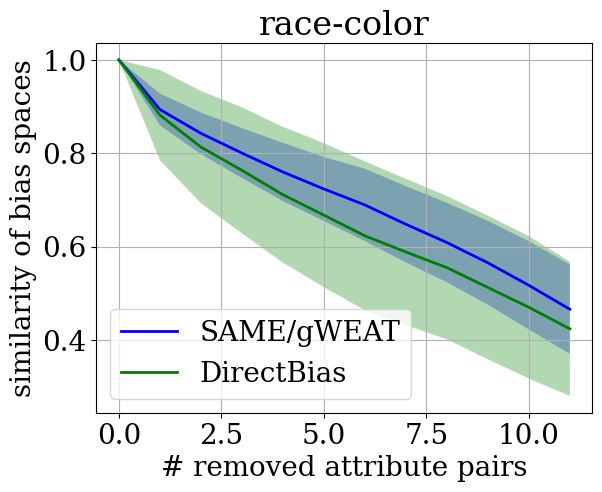

gender


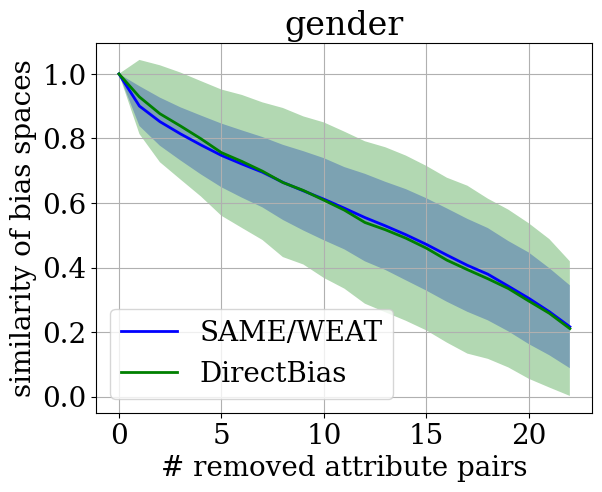

age


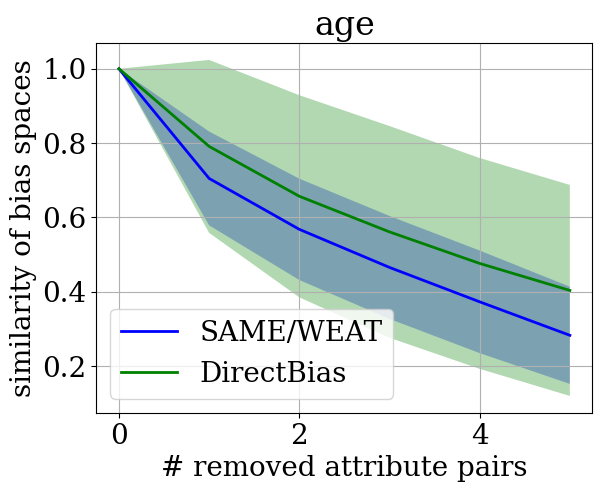

religion


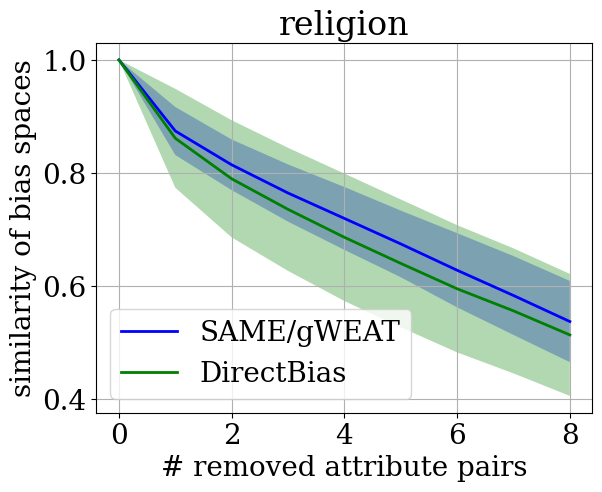

In [11]:
for bt, res in results.items():
    print(bt)

    remove_n = list(res['SAME'].keys())
    same_mu = np.asarray([np.mean(res['SAME'][n]) for n in remove_n])
    same_sigma = np.asarray([np.std(res['SAME'][n]) for n in remove_n])
    db_mu = np.asarray([np.mean(res['DB'][n]) for n in remove_n])
    db_sigma = np.asarray([np.std(res['DB'][n]) for n in remove_n])
    gweat_mu = np.asarray([np.mean(res['gWEAT'][n]) for n in remove_n])
    gweat_sigma = np.asarray([np.std(res['gWEAT'][n]) for n in remove_n])
    
    fig, ax = plt.subplots(1)
    #ax.plot(remove_n, gweat_mu, lw=2, label='gWEAT', color='orange')
    if bt in ['age','gender']:
        ax.plot(remove_n, same_mu, lw=2, label='SAME/WEAT', color='blue')
    else: #lif bt == 'race-color':
        ax.plot(remove_n, same_mu, lw=2, label='SAME/gWEAT', color='blue')
    #else:
    #    ax.plot(remove_n, same_mu, lw=2, label='SAME', color='blue')
    #    ax.plot(remove_n, gweat_mu, lw=2, label='gWEAT', color='orange')
    #    ax.fill_between(remove_n, gweat_mu+gweat_sigma, gweat_mu-gweat_sigma, facecolor='orange', alpha=0.3)
    ax.plot(remove_n, db_mu, lw=2, label='DirectBias', color='green')
    ax.fill_between(remove_n, same_mu+same_sigma, same_mu-same_sigma, facecolor='blue', alpha=0.3)
    ax.fill_between(remove_n, db_mu+db_sigma, db_mu-db_sigma, facecolor='green', alpha=0.3)
    #ax.set_title('Similarity of bias space after removing attributes (%s)' % bt)
    ax.set_title(bt)
    ax.legend(loc='lower left')
    ax.set_xlabel('# removed attribute pairs')
    ax.set_ylabel('similarity of bias spaces')
    ax.grid()
    plt.savefig('plots/attribute_robustness_'+bt+'.png', bbox_inches="tight")
    plt.show()

## Robustness to target selection

In [16]:
bias_types = ['gender']
cosine_scores = {'SAME': SAME(), 'WEAT': WEAT(), 'DirectBias': DirectBias(k=1), 'MAC': MAC()}  
factors=[0.01, 0.03, 0.05, 0.1, 0.2]
models=["albert-large-v2", "google/electra-base-generator", "google/electra-large-generator", "bert-base-multilingual-uncased", "GroNLP/hateBERT", "Twitter/twhin-bert-base", "medicalai/ClinicalBERT", "albert-xlarge-v2", "bert-large-uncased-whole-word-masking", "abhi1nandy2/Bible-roberta-base", "distilbert-base-uncased-finetuned-sst-2-english", "gpt2", "openai-gpt", "xlnet-base-cased", "bert-base-uncased", "bert-large-uncased", "distilbert-base-uncased", "roberta-base", "roberta-large", "distilroberta-base", "xlm-roberta-base", "albert-base-v2"]

In [17]:
with open('results/robustness_results.pickle', 'rb') as handle:
    res_by_model = pickle.load(handle)

SAME
[0.0017842504334638265, 0.0010132751734166473, 0.000752305911859533, 0.0005031617130732312, 0.00033123200459993365]
DirectBias
[0.0027861755975225316, 0.001623973886288552, 0.001250397038613605, 0.0007699173786824838, 0.0005120897690271898]
WEAT
[0.04436137999910885, 0.023508152410266964, 0.01753624903678006, 0.013225509309140347, 0.00852679425086336]


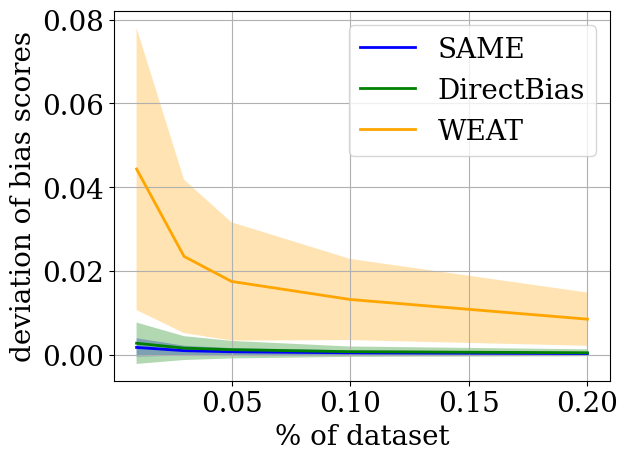

SAME
[0.04580254693009791, 0.045807890808203876, 0.04580642089163263, 0.04578367839215738, 0.045758629324071376]
DirectBias
[0.11272486723974681, 0.11265998313440967, 0.11265328356480629, 0.11260052606522193, 0.11250305345431048]
WEAT
[0.12105203257817172, 0.11659672578256944, 0.11573717549917963, 0.11522326591119195, 0.1151016300357733]


In [18]:
score_color_tup = [('SAME', 'blue'), ('DirectBias', 'green'), ('WEAT', 'orange')]
for test in ['bios_subset', 'titles/bios']:
    all_dev = {score: {factor: [] for factor in factors} for score in ['SAME','DirectBias', 'WEAT']}
    for (score, color) in score_color_tup:
        print(score)
        for model in models:
            for factor in factors:
                all_dev[score][factor] += res_by_model[model][score][test][factor]
        print([np.mean(all_dev[score][factor]) for factor in factors])

    if test == 'bios_subset':
        fig, ax = plt.subplots(1)
        for (score, color) in score_color_tup:
            mu_all_dev = np.asarray([np.mean(all_dev[score][factor]) for factor in factors])
            sigma_all_dev = np.asarray([np.std(all_dev[score][factor]) for factor in factors])
            ax.plot(factors, mu_all_dev, lw=2, label=score, color=color)
            ax.fill_between(factors, mu_all_dev+sigma_all_dev, mu_all_dev-sigma_all_dev, facecolor=color, alpha=0.3)
            
        #ax.set_title(test)
        ax.legend(loc='upper right')
        ax.set_xlabel('% of dataset')
        ax.set_ylabel('deviation of bias scores')
        ax.grid()
        plt.savefig('plots/target_robustness_bios_weat.png', bbox_inches="tight")
        plt.show()   

SAME
[0.0017842504334638265, 0.0010132751734166473, 0.000752305911859533, 0.0005031617130732312, 0.00033123200459993365]
DirectBias
[0.0027861755975225316, 0.001623973886288552, 0.001250397038613605, 0.0007699173786824838, 0.0005120897690271898]


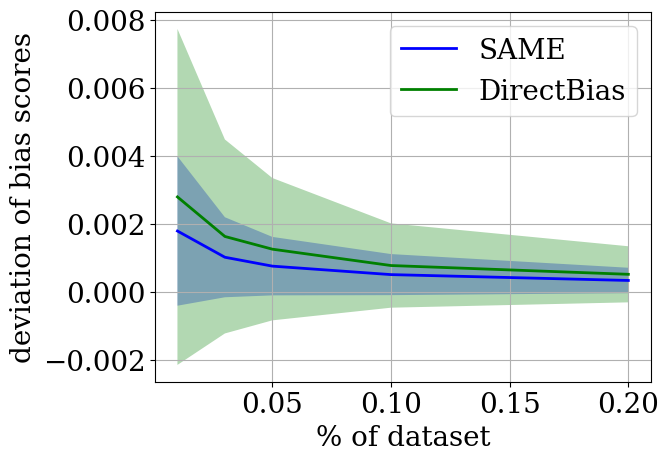

SAME
[0.04580254693009791, 0.045807890808203876, 0.04580642089163263, 0.04578367839215738, 0.045758629324071376]
DirectBias
[0.11272486723974681, 0.11265998313440967, 0.11265328356480629, 0.11260052606522193, 0.11250305345431048]


In [19]:
score_color_tup = [('SAME', 'blue'), ('DirectBias', 'green')]#, ('WEAT', 'orange')]
for test in ['bios_subset', 'titles/bios']:
    all_dev = {score: {factor: [] for factor in factors} for score in ['SAME','DirectBias', 'WEAT']}
    for (score, color) in score_color_tup:
        print(score)
        for model in models:
            for factor in factors:
                all_dev[score][factor] += res_by_model[model][score][test][factor]
        print([np.mean(all_dev[score][factor]) for factor in factors])

    if test == 'bios_subset':
        fig, ax = plt.subplots(1)
        for (score, color) in score_color_tup:
            mu_all_dev = np.asarray([np.mean(all_dev[score][factor]) for factor in factors])
            sigma_all_dev = np.asarray([np.std(all_dev[score][factor]) for factor in factors])
            ax.plot(factors, mu_all_dev, lw=2, label=score, color=color)
            ax.fill_between(factors, mu_all_dev+sigma_all_dev, mu_all_dev-sigma_all_dev, facecolor=color, alpha=0.3)
            
        #ax.set_title(test)
        ax.legend(loc='upper right')
        ax.set_xlabel('% of dataset')
        ax.set_ylabel('deviation of bias scores')
        ax.grid()
        plt.savefig('plots/target_robustness_bios.png', bbox_inches="tight")
        plt.show()   